In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "hybridqnn_shallow" #hybridqnn_shallow
# train args
batch_size = 1
epochs = 10
LR = 0.001
n_samples_train = 200 #128
n_samples_test = 50 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "CIFAR100" # MNIST / CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ['fish','apple'] # ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['fish', 'apple']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

if network == 'hybridqnn_shallow' or network == 'QSVM':
    # Set preprocessing transforms
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
else:
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Files already downloaded and verified
Files already downloaded and verified
Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: 0.00023650005459785461 s


<Figure size 432x288 with 0 Axes>

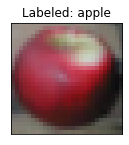

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        #n_filts_fc1 = int(((((input_resolution[0])/2)-4)/2)**2)*16 # +7
        n_filts_fc1 = 256
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
HybridQNN_Shallow(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)
Network init elapsed time: -0.00039108656346797943 s


Batch 0, Loss: 0.2588122487068176
Batch 1, Loss: -1.3727190494537354
Batch 2, Loss: 0.30189457535743713
Batch 3, Loss: -1.2926857471466064
Batch 4, Loss: -1.2980340719223022
Batch 5, Loss: -1.4221248626708984
Batch 6, Loss: -1.440446376800537
Batch 7, Loss: -1.1996232271194458
Batch 8, Loss: 0.5124842524528503
Batch 9, Loss: -1.2448395490646362
Batch 10, Loss: -1.611942172050476
Batch 11, Loss: -1.3116666078567505
Batch 12, Loss: -1.3752849102020264
Batch 13, Loss: 0.30929380655288696
Batch 14, Loss: -1.497912883758545
Batch 15, Loss: 0.5144872069358826
Batch 16, Loss: 0.6283481121063232
Batch 17, Loss: -1.4871702194213867
Batch 18, Loss: -1.6485179662704468
Batch 19, Loss: -1.414034366607666
Batch 20, Loss: 0.46465522050857544
Batch 21, Loss: 0.5277193784713745
Batch 22, Loss: -1.5836567878723145
Batch 23, Loss: -1.6559722423553467
Batch 24, Loss: -1.5888381004333496
Batch 25, Loss: -1.533888816833496
Batch 26, Loss: 0.471618115901947
Batch 27, Loss: -1.393414855003357
Batch 28, Loss:

Batch 228, Loss: 0.3454056680202484
Batch 229, Loss: 0.41423165798187256
Batch 230, Loss: 0.15803436934947968
Batch 231, Loss: 0.1584128439426422
Batch 232, Loss: 0.16020505130290985
Batch 233, Loss: -1.1760333776474
Batch 234, Loss: 0.2731703221797943
Batch 235, Loss: -1.4008419513702393
Batch 236, Loss: 0.299980491399765
Batch 237, Loss: 0.3574437201023102
Batch 238, Loss: 0.17037436366081238
Batch 239, Loss: 0.1506514847278595
Batch 240, Loss: 0.36612844467163086
Batch 241, Loss: 0.2791845500469208
Batch 242, Loss: 0.10401096940040588
Batch 243, Loss: 0.08870571851730347
Batch 244, Loss: 0.08814570307731628
Batch 245, Loss: 0.1609172374010086
Batch 246, Loss: -1.098236322402954
Batch 247, Loss: -1.2929198741912842
Batch 248, Loss: 0.3311697542667389
Batch 249, Loss: -1.127856969833374
Batch 250, Loss: 0.06930160522460938
Batch 251, Loss: 0.14442814886569977
Batch 252, Loss: -1.0612977743148804
Batch 253, Loss: 0.2530902922153473
Batch 254, Loss: 0.08640927076339722
Batch 255, Loss: 

Batch 53, Loss: -1.4168353080749512
Batch 54, Loss: -1.6560497283935547
Batch 55, Loss: -1.4430493116378784
Batch 56, Loss: 0.3670339584350586
Batch 57, Loss: 0.35118016600608826
Batch 58, Loss: 0.471291720867157
Batch 59, Loss: 0.352267324924469
Batch 60, Loss: -1.4390807151794434
Batch 61, Loss: -1.5953460931777954
Batch 62, Loss: -1.3795193433761597
Batch 63, Loss: 0.27252915501594543
Batch 64, Loss: -1.5892919301986694
Batch 65, Loss: -1.2681361436843872
Batch 66, Loss: 0.20084138214588165
Batch 67, Loss: -1.489824652671814
Batch 68, Loss: 0.2300788164138794
Batch 69, Loss: 0.17786909639835358
Batch 70, Loss: -1.673468828201294
Batch 71, Loss: -1.109921932220459
Batch 72, Loss: 0.3143109679222107
Batch 73, Loss: -1.286578893661499
Batch 74, Loss: 0.2783259153366089
Batch 75, Loss: 0.3628549575805664
Batch 76, Loss: 0.49949848651885986
Batch 77, Loss: -1.194149374961853
Batch 78, Loss: -1.0719044208526611
Batch 79, Loss: -1.054772138595581
Batch 80, Loss: 0.13855063915252686
Batch 8

Batch 279, Loss: -1.2467045783996582
Batch 280, Loss: -1.6108615398406982
Batch 281, Loss: -1.3706419467926025
Batch 282, Loss: -1.277622938156128
Batch 283, Loss: 0.195111483335495
Batch 284, Loss: -1.15692138671875
Batch 285, Loss: -1.6708643436431885
Batch 286, Loss: -1.3210119009017944
Batch 287, Loss: 0.658233642578125
Batch 288, Loss: -1.1908576488494873
Batch 289, Loss: 0.2124248743057251
Batch 290, Loss: -1.4048457145690918
Batch 291, Loss: -1.2403197288513184
Batch 292, Loss: 0.3141762316226959
Batch 293, Loss: -1.588602900505066
Batch 294, Loss: -1.2151033878326416
Batch 295, Loss: 0.2232406586408615
Batch 296, Loss: -1.2182928323745728
Batch 297, Loss: 0.4581795930862427
Batch 298, Loss: -1.2924593687057495
Batch 299, Loss: 0.5228549838066101
Batch 300, Loss: 0.228739932179451
Batch 301, Loss: -1.712639570236206
Batch 302, Loss: -1.4362568855285645
Batch 303, Loss: 0.4203987717628479
Batch 304, Loss: 0.5401278734207153
Batch 305, Loss: 0.45541754364967346
Batch 306, Loss: 0.

Batch 106, Loss: -1.6136283874511719
Batch 107, Loss: -1.3827500343322754
Batch 108, Loss: -1.4232182502746582
Batch 109, Loss: 0.6318864822387695
Batch 110, Loss: -1.498328447341919
Batch 111, Loss: -1.3855575323104858
Batch 112, Loss: -1.0723003149032593
Batch 113, Loss: 0.5905336737632751
Batch 114, Loss: -1.4528207778930664
Batch 115, Loss: 0.13158999383449554
Batch 116, Loss: 0.45593249797821045
Batch 117, Loss: 0.6117305159568787
Batch 118, Loss: 0.40122082829475403
Batch 119, Loss: -1.5145853757858276
Batch 120, Loss: 0.23602376878261566
Batch 121, Loss: -1.1895943880081177
Batch 122, Loss: 0.40051668882369995
Batch 123, Loss: 0.4476710855960846
Batch 124, Loss: -1.438241958618164
Batch 125, Loss: -1.1140351295471191
Batch 126, Loss: -1.3473994731903076
Batch 127, Loss: 0.2910236120223999
Batch 128, Loss: 0.5113310813903809
Batch 129, Loss: -1.4930821657180786
Batch 130, Loss: 0.6289783120155334
Batch 131, Loss: -1.3289427757263184
Batch 132, Loss: -1.364324688911438
Batch 133, 

Batch 330, Loss: -1.2323687076568604
Batch 331, Loss: 0.47480446100234985
Batch 332, Loss: -1.5801918506622314
Batch 333, Loss: -1.3340567350387573
Batch 334, Loss: 0.5144633054733276
Batch 335, Loss: 0.31732866168022156
Batch 336, Loss: 0.2932642102241516
Batch 337, Loss: 0.30157768726348877
Batch 338, Loss: -1.3137593269348145
Batch 339, Loss: 0.3680621087551117
Batch 340, Loss: -1.404802680015564
Batch 341, Loss: -1.3600565195083618
Batch 342, Loss: -1.0791716575622559
Batch 343, Loss: 0.656740665435791
Batch 344, Loss: 0.40300509333610535
Batch 345, Loss: -1.255695104598999
Batch 346, Loss: 0.5551638603210449
Batch 347, Loss: 0.3692520260810852
Batch 348, Loss: -1.467710256576538
Batch 349, Loss: 0.44524383544921875
Batch 350, Loss: -1.435485601425171
Batch 351, Loss: 0.1622541844844818
Batch 352, Loss: 0.3776837885379791
Batch 353, Loss: -1.5653867721557617
Batch 354, Loss: 0.19450239837169647
Batch 355, Loss: -1.1226500272750854
Batch 356, Loss: -1.5581843852996826
Batch 357, Los

Batch 157, Loss: -1.4513461589813232
Batch 158, Loss: -1.235317349433899
Batch 159, Loss: -1.499528408050537
Batch 160, Loss: 0.4630318284034729
Batch 161, Loss: -1.2304725646972656
Batch 162, Loss: -1.5915052890777588
Batch 163, Loss: 0.31274083256721497
Batch 164, Loss: -1.2569555044174194
Batch 165, Loss: 0.5543427467346191
Batch 166, Loss: 0.1395508050918579
Batch 167, Loss: 0.04050740599632263
Batch 168, Loss: 0.3663313388824463
Batch 169, Loss: -1.3863213062286377
Batch 170, Loss: -1.0106889009475708
Batch 171, Loss: -1.3815828561782837
Batch 172, Loss: 0.10962027311325073
Batch 173, Loss: -1.6175230741500854
Batch 174, Loss: 0.3060075640678406
Batch 175, Loss: 0.2213314026594162
Batch 176, Loss: 0.3261551260948181
Batch 177, Loss: -1.5221915245056152
Batch 178, Loss: 0.09964975714683533
Batch 179, Loss: -1.0796324014663696
Batch 180, Loss: -1.6715539693832397
Batch 181, Loss: 0.2604946196079254
Batch 182, Loss: -1.3510339260101318
Batch 183, Loss: 0.6466683149337769
Batch 184, L

Batch 381, Loss: -1.5506787300109863
Batch 382, Loss: -1.6177778244018555
Batch 383, Loss: -1.1059496402740479
Batch 384, Loss: -1.3368494510650635
Batch 385, Loss: 0.3298299312591553
Batch 386, Loss: -1.3502638339996338
Batch 387, Loss: -1.2024937868118286
Batch 388, Loss: -1.5865665674209595
Batch 389, Loss: 0.4538499414920807
Batch 390, Loss: -1.118939995765686
Batch 391, Loss: -1.0597124099731445
Batch 392, Loss: 0.6360158920288086
Batch 393, Loss: 0.6353909373283386
Batch 394, Loss: 0.21465161442756653
Batch 395, Loss: -1.1951541900634766
Batch 396, Loss: 0.11137190461158752
Batch 397, Loss: -1.4365506172180176
Batch 398, Loss: -1.1788101196289062
Batch 399, Loss: -1.1113449335098267
Training [40%]	Loss: -0.5009
Batch 0, Loss: 0.26366880536079407
Batch 1, Loss: -1.2168192863464355
Batch 2, Loss: 0.08636260032653809
Batch 3, Loss: 0.4982450604438782
Batch 4, Loss: -1.6540324687957764
Batch 5, Loss: -1.6831324100494385
Batch 6, Loss: 0.32518625259399414
Batch 7, Loss: 0.075320184230

Batch 207, Loss: 0.09562185406684875
Batch 208, Loss: -1.463837742805481
Batch 209, Loss: 0.4788205027580261
Batch 210, Loss: 0.2750921845436096
Batch 211, Loss: -1.4000215530395508
Batch 212, Loss: 0.29148751497268677
Batch 213, Loss: -1.408435344696045
Batch 214, Loss: -1.5109925270080566
Batch 215, Loss: -1.376131296157837
Batch 216, Loss: -1.4154160022735596
Batch 217, Loss: -1.1516752243041992
Batch 218, Loss: 0.7276430130004883
Batch 219, Loss: 0.20685167610645294
Batch 220, Loss: -1.5506781339645386
Batch 221, Loss: -1.7183738946914673
Batch 222, Loss: -1.2415406703948975
Batch 223, Loss: 0.230751171708107
Batch 224, Loss: -1.0777949094772339
Batch 225, Loss: 0.36438798904418945
Batch 226, Loss: 0.46176040172576904
Batch 227, Loss: -1.397043228149414
Batch 228, Loss: -1.3085334300994873
Batch 229, Loss: 0.3599131405353546
Batch 230, Loss: -1.3197691440582275
Batch 231, Loss: -1.2173819541931152
Batch 232, Loss: -1.463240623474121
Batch 233, Loss: -1.271154761314392
Batch 234, Lo

Batch 32, Loss: 0.15283671021461487
Batch 33, Loss: 0.35680168867111206
Batch 34, Loss: 0.6544300317764282
Batch 35, Loss: 0.09079119563102722
Batch 36, Loss: -1.5392957925796509
Batch 37, Loss: 0.6585489511489868
Batch 38, Loss: 0.7064722776412964
Batch 39, Loss: -1.3951389789581299
Batch 40, Loss: 0.3538171350955963
Batch 41, Loss: 0.3131207227706909
Batch 42, Loss: 0.284089595079422
Batch 43, Loss: -1.6428414583206177
Batch 44, Loss: -1.0886439085006714
Batch 45, Loss: 0.44318056106567383
Batch 46, Loss: 0.3293965756893158
Batch 47, Loss: 0.11929696798324585
Batch 48, Loss: 0.10393577814102173
Batch 49, Loss: 0.08986029028892517
Batch 50, Loss: 0.3041272759437561
Batch 51, Loss: -1.118707299232483
Batch 52, Loss: 0.3974805474281311
Batch 53, Loss: -1.2818316221237183
Batch 54, Loss: 0.7204943895339966
Batch 55, Loss: 0.6324183940887451
Batch 56, Loss: -1.6162165403366089
Batch 57, Loss: -1.0327670574188232
Batch 58, Loss: 0.619875431060791
Batch 59, Loss: -1.0495424270629883
Batch 6

Batch 258, Loss: -1.4160640239715576
Batch 259, Loss: 0.2162480652332306
Batch 260, Loss: -1.4239917993545532
Batch 261, Loss: -1.1458566188812256
Batch 262, Loss: -1.1856789588928223
Batch 263, Loss: -1.579924464225769
Batch 264, Loss: -1.1493914127349854
Batch 265, Loss: 0.45231252908706665
Batch 266, Loss: 0.5735054612159729
Batch 267, Loss: 0.3221668601036072
Batch 268, Loss: -1.6508148908615112
Batch 269, Loss: 0.6019684672355652
Batch 270, Loss: 0.012483000755310059
Batch 271, Loss: 0.0008645057678222656
Batch 272, Loss: -1.5134204626083374
Batch 273, Loss: 0.4044482111930847
Batch 274, Loss: 0.4994399845600128
Batch 275, Loss: -1.1894373893737793
Batch 276, Loss: 0.4877544641494751
Batch 277, Loss: 0.6409474015235901
Batch 278, Loss: 0.26433509588241577
Batch 279, Loss: -1.3272712230682373
Batch 280, Loss: 0.2595750689506531
Batch 281, Loss: -1.3494181632995605
Batch 282, Loss: 0.38933396339416504
Batch 283, Loss: 0.2342807650566101
Batch 284, Loss: 0.7256218791007996
Batch 285,

Batch 84, Loss: -0.9897037744522095
Batch 85, Loss: -1.2857941389083862
Batch 86, Loss: 0.33655086159706116
Batch 87, Loss: 0.17196542024612427
Batch 88, Loss: 0.3235577344894409
Batch 89, Loss: 0.0912335216999054
Batch 90, Loss: -1.37751042842865
Batch 91, Loss: -1.3873265981674194
Batch 92, Loss: -1.287063479423523
Batch 93, Loss: 0.2562646269798279
Batch 94, Loss: -1.4674038887023926
Batch 95, Loss: 0.16388942301273346
Batch 96, Loss: -1.3969230651855469
Batch 97, Loss: 0.2087075412273407
Batch 98, Loss: -1.5158874988555908
Batch 99, Loss: -1.4258731603622437
Batch 100, Loss: 0.2692229151725769
Batch 101, Loss: -0.029054373502731323
Batch 102, Loss: -1.7414734363555908
Batch 103, Loss: 0.21521861851215363
Batch 104, Loss: 0.49342766404151917
Batch 105, Loss: -1.1295756101608276
Batch 106, Loss: -1.0824053287506104
Batch 107, Loss: -1.1653517484664917
Batch 108, Loss: 0.08460187911987305
Batch 109, Loss: -1.2823885679244995
Batch 110, Loss: 0.3743307590484619
Batch 111, Loss: 0.25871

Batch 309, Loss: 0.4354156255722046
Batch 310, Loss: 0.14571112394332886
Batch 311, Loss: 0.45841825008392334
Batch 312, Loss: -1.2135965824127197
Batch 313, Loss: -1.4800435304641724
Batch 314, Loss: -1.5111335515975952
Batch 315, Loss: 0.5827317833900452
Batch 316, Loss: 0.29427435994148254
Batch 317, Loss: 0.17084862291812897
Batch 318, Loss: -1.3534247875213623
Batch 319, Loss: -1.4639747142791748
Batch 320, Loss: -1.4743735790252686
Batch 321, Loss: -1.0353596210479736
Batch 322, Loss: 0.6401186585426331
Batch 323, Loss: -1.6237143278121948
Batch 324, Loss: 0.27936166524887085
Batch 325, Loss: 0.2972673773765564
Batch 326, Loss: -1.5628325939178467
Batch 327, Loss: 0.08917832374572754
Batch 328, Loss: 0.6768831014633179
Batch 329, Loss: -1.0737073421478271
Batch 330, Loss: -1.182574987411499
Batch 331, Loss: -1.0861616134643555
Batch 332, Loss: 0.3240499496459961
Batch 333, Loss: 0.06255367398262024
Batch 334, Loss: -1.224149465560913
Batch 335, Loss: 0.38641494512557983
Batch 336

Batch 135, Loss: 0.3492078483104706
Batch 136, Loss: 0.4792693257331848
Batch 137, Loss: 0.1853998750448227
Batch 138, Loss: 0.5625036954879761
Batch 139, Loss: -1.3047676086425781
Batch 140, Loss: 0.07043704390525818
Batch 141, Loss: 0.37938088178634644
Batch 142, Loss: 0.22028620541095734
Batch 143, Loss: 0.4222196042537689
Batch 144, Loss: -1.470268726348877
Batch 145, Loss: -1.3586217164993286
Batch 146, Loss: -1.2253220081329346
Batch 147, Loss: -1.5173619985580444
Batch 148, Loss: 0.3422822654247284
Batch 149, Loss: 0.12937869131565094
Batch 150, Loss: -1.6487082242965698
Batch 151, Loss: 0.09966495633125305
Batch 152, Loss: 0.17687807977199554
Batch 153, Loss: -1.201013445854187
Batch 154, Loss: -1.164473295211792
Batch 155, Loss: 0.18587520718574524
Batch 156, Loss: -1.1320257186889648
Batch 157, Loss: 0.2586002051830292
Batch 158, Loss: 0.003385603427886963
Batch 159, Loss: 0.07076716423034668
Batch 160, Loss: 0.5845605134963989
Batch 161, Loss: -0.009418308734893799
Batch 162

Batch 359, Loss: -1.2609033584594727
Batch 360, Loss: -1.426663875579834
Batch 361, Loss: -1.2520349025726318
Batch 362, Loss: -1.2189451456069946
Batch 363, Loss: -0.03046661615371704
Batch 364, Loss: -1.3669291734695435
Batch 365, Loss: -1.4953029155731201
Batch 366, Loss: 0.3567367494106293
Batch 367, Loss: -1.103548288345337
Batch 368, Loss: 0.5851681232452393
Batch 369, Loss: 0.2324078232049942
Batch 370, Loss: 0.46216729283332825
Batch 371, Loss: -1.0506702661514282
Batch 372, Loss: -1.1939127445220947
Batch 373, Loss: 0.38126856088638306
Batch 374, Loss: -1.4346967935562134
Batch 375, Loss: -1.4028546810150146
Batch 376, Loss: 0.3093704283237457
Batch 377, Loss: -1.3333081007003784
Batch 378, Loss: -1.5049110651016235
Batch 379, Loss: 0.6665451526641846
Batch 380, Loss: 0.4778435230255127
Batch 381, Loss: -1.7050384283065796
Batch 382, Loss: -1.5206412076950073
Batch 383, Loss: 0.16652552783489227
Batch 384, Loss: 0.4072537422180176
Batch 385, Loss: -1.003938913345337
Batch 386,

Batch 186, Loss: -1.0376334190368652
Batch 187, Loss: -1.3149645328521729
Batch 188, Loss: 0.5746787786483765
Batch 189, Loss: 0.5756492614746094
Batch 190, Loss: 0.1062048077583313
Batch 191, Loss: 0.6488213539123535
Batch 192, Loss: 0.26463228464126587
Batch 193, Loss: 0.4235292375087738
Batch 194, Loss: -1.6130387783050537
Batch 195, Loss: 0.2111896276473999
Batch 196, Loss: 0.4042655825614929
Batch 197, Loss: -1.5105223655700684
Batch 198, Loss: 0.32707980275154114
Batch 199, Loss: 0.726469874382019
Batch 200, Loss: 0.3601369559764862
Batch 201, Loss: 0.5974321365356445
Batch 202, Loss: 0.3240366578102112
Batch 203, Loss: -1.4980674982070923
Batch 204, Loss: -1.4972368478775024
Batch 205, Loss: 0.4369693398475647
Batch 206, Loss: -1.6459472179412842
Batch 207, Loss: 0.7109371423721313
Batch 208, Loss: 0.6281172037124634
Batch 209, Loss: 0.4419785439968109
Batch 210, Loss: 0.18823395669460297
Batch 211, Loss: -1.6832382678985596
Batch 212, Loss: 0.3231128454208374
Batch 213, Loss: 0

Batch 10, Loss: -1.1047768592834473
Batch 11, Loss: 0.5100514888763428
Batch 12, Loss: 0.7004193663597107
Batch 13, Loss: 0.016131222248077393
Batch 14, Loss: -1.25845205783844
Batch 15, Loss: -1.2118604183197021
Batch 16, Loss: 0.2303987443447113
Batch 17, Loss: 0.15676021575927734
Batch 18, Loss: -1.2537446022033691
Batch 19, Loss: -1.6398454904556274
Batch 20, Loss: 0.35487350821495056
Batch 21, Loss: -1.2364492416381836
Batch 22, Loss: -1.729350209236145
Batch 23, Loss: 0.48101574182510376
Batch 24, Loss: -1.5001680850982666
Batch 25, Loss: -1.3198883533477783
Batch 26, Loss: 0.48176896572113037
Batch 27, Loss: 0.6545152068138123
Batch 28, Loss: -1.6717276573181152
Batch 29, Loss: -1.4030406475067139
Batch 30, Loss: 0.24079656600952148
Batch 31, Loss: -1.237000823020935
Batch 32, Loss: 0.219223290681839
Batch 33, Loss: -1.3650312423706055
Batch 34, Loss: -1.7260667085647583
Batch 35, Loss: -1.3732781410217285
Batch 36, Loss: 0.6561254262924194
Batch 37, Loss: -1.2457078695297241
Ba

Batch 236, Loss: 0.4266800880432129
Batch 237, Loss: -1.067582368850708
Batch 238, Loss: -1.3588658571243286
Batch 239, Loss: -1.1213841438293457
Batch 240, Loss: -1.3574546575546265
Batch 241, Loss: 0.29164355993270874
Batch 242, Loss: -1.713389277458191
Batch 243, Loss: 0.3075452446937561
Batch 244, Loss: -1.2582365274429321
Batch 245, Loss: 0.29487448930740356
Batch 246, Loss: 0.40495380759239197
Batch 247, Loss: 0.5611340999603271
Batch 248, Loss: 0.18882878124713898
Batch 249, Loss: 0.4471490979194641
Batch 250, Loss: 0.09332966804504395
Batch 251, Loss: -1.3741025924682617
Batch 252, Loss: -1.055171251296997
Batch 253, Loss: 0.23650366067886353
Batch 254, Loss: 0.6482698917388916
Batch 255, Loss: -1.1697068214416504
Batch 256, Loss: 0.5394764542579651
Batch 257, Loss: 0.12609438598155975
Batch 258, Loss: 0.5080733299255371
Batch 259, Loss: 0.29518842697143555
Batch 260, Loss: -1.0476617813110352
Batch 261, Loss: 0.4980780780315399
Batch 262, Loss: 0.5960279703140259
Batch 263, Lo

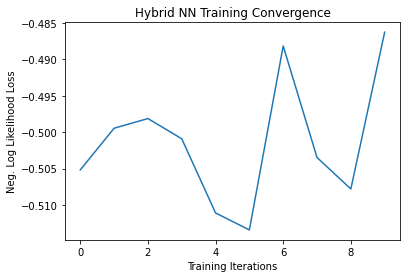

Training time: -0.0007068701088428497 s


In [7]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass
            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

In [8]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


Performance on test data:
	Loss: -0.4885
	Accuracy: 50.0%
Test time: 0.00028241705149412155 s


<Figure size 432x288 with 0 Axes>

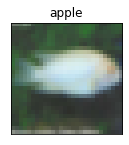

In [9]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 